In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing and exploring data

In [ ]:
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix, hstack

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, make_scorer

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white")

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mercari/train.tsv', sep='\t')
# test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mercari/test.tsv', sep='\t')

In [ ]:
train.shape

(1482535, 8)

In [ ]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


The files consist of a list of product listings. These files are tab-delimited.

- train_id or test_id - the id of the listing
- name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm]
- item_condition_id - the condition of the items provided by the seller
- category_name - category of the listing
- brand_name
- price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
- shipping - 1 if shipping fee is paid by seller and 0 by buyer
- item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


## Price

In [ ]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

Text(0.5, 1.0, 'Price Distribution - Training Set')

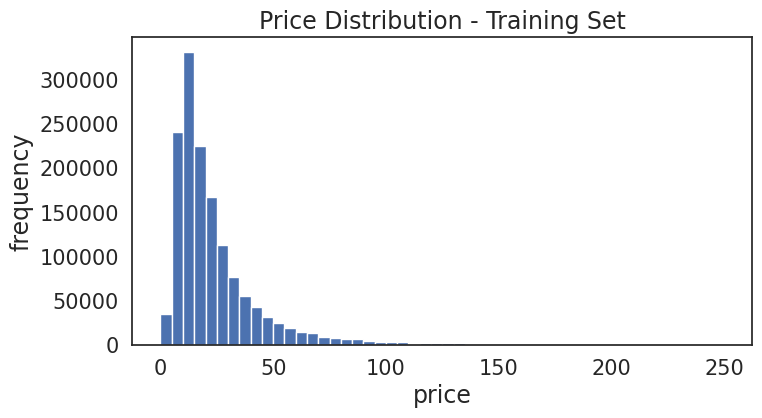

In [ ]:
train.price.plot.hist(bins=50, figsize=(8,4), edgecolor='white',range=[0,250])
plt.xlabel('price', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)


Plotting the price distribution shows that it is skewed to the right. By using a logarithmic transformation, the price distribution becomes normal, which later contributes to the performance of the model.

Text(0.5, 1.0, 'Log(Price) Distribution - Training Set')

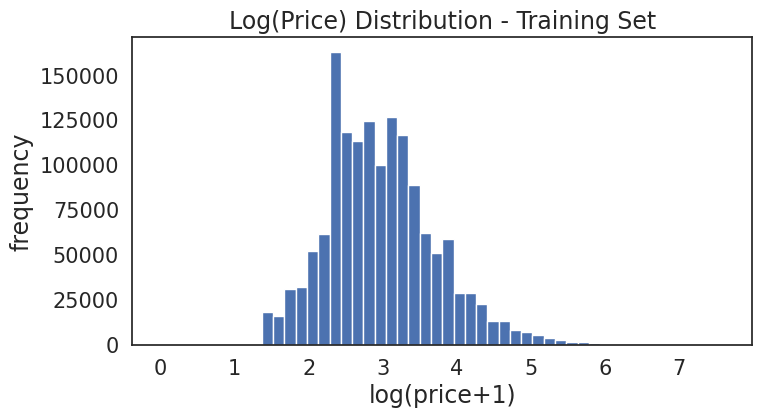

In [ ]:
np.log1p(train['price']).plot.hist(bins=50, figsize=(8,4), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)

## Shipping

In [ ]:
train.shipping.value_counts()/len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

<Axes: ylabel='shipping'>

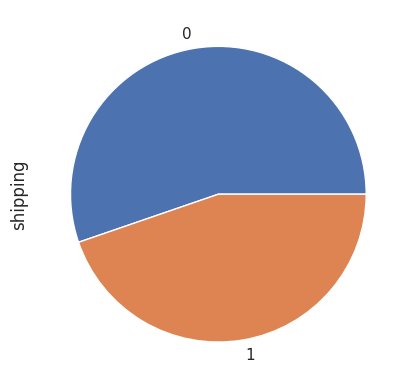

In [ ]:
train.shipping.value_counts().plot.pie()

In [ ]:
prc_shipBySeller = train.loc[train.shipping==1, 'price']
prc_shipByBuyer = train.loc[train.shipping==0, 'price']

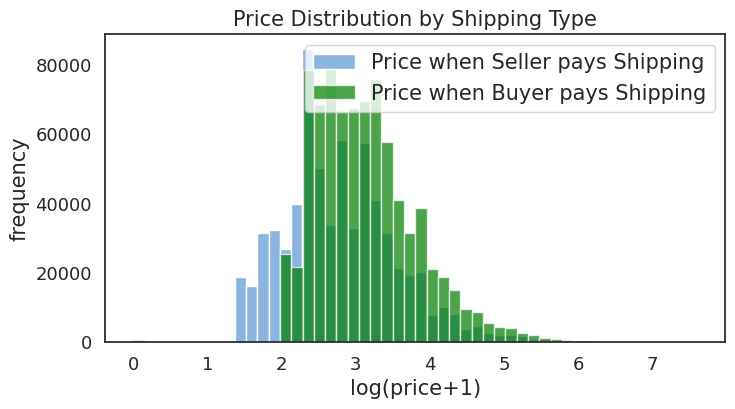

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(np.log(prc_shipBySeller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
ax.legend(fontsize=15)
plt.xlabel('log(price+1)', fontsize=15)
plt.ylabel('frequency', fontsize=15)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=13)
plt.show()

By plotting the price distribution in relation to the 'shipping' attribute, we notice the difference in the product price between the two categories of this attribute, which means that the 'shipping' attribute is important in predicting the product price.

## Category

In [ ]:
train.category_name.nunique()

1287

In [ ]:
train.category_name.value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Blouse                                    20284
Women/Tops & Blouses/Tank, Cami                                20284
Name: category_name, dtype: int64

'Category_name' contains three categories separated by '/', which means that from that one attribute we will make three new attributes 'general_cat', 'subcat_1' and 'subcat_2'.

In [ ]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [ ]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [ ]:
print('Number of unique categories in general_cat:',train.general_cat.nunique())
print('Number of unique categories in subcat_1:',train.subcat_1.nunique())
print('Number of unique categories in subcat_2:',train.subcat_2.nunique())

Number of unique categories in general_cat: 11
Number of unique categories in subcat_1: 114
Number of unique categories in subcat_2: 871


## Brand name

In [ ]:
train.brand_name.nunique()

4809

In [ ]:
train.brand_name.value_counts()[:5]

PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
Name: brand_name, dtype: int64

## Item description

In [ ]:
train.item_description.head

<bound method NDFrame.head of 0                                         No description yet
1          This keyboard is in great condition and works ...
2          Adorable top with a hint of lace and a key hol...
3          New with tags. Leather horses. Retail for [rm]...
4                  Complete with certificate of authenticity
                                 ...                        
1482530    Lace, says size small but fits medium perfectl...
1482531     Little mermaid handmade dress never worn size 2t
1482532            Used once or twice, still in great shape.
1482533    There is 2 of each one that you see! So 2 red ...
1482534    New with tag, red with sparkle. Firm price, no...
Name: item_description, Length: 1482535, dtype: object>

# Preprocessing

In [ ]:
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 40000

## Handling missing values

In [ ]:
train.isna().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
general_cat               0
subcat_1                  0
subcat_2                  0
dtype: int64

The attribute 'brand_name' contains the most missing values ​​that will be replaced by the new value 'Missing'.
Rows for which 'item_description' is undefined will be removed.
'Category_name' is transformed into three new columns that have no missing values.

In [ ]:
train.brand_name.loc[train.brand_name.isna()] = 'Missing'
train = train[pd.notnull(train['item_description'])]

## Converting to categorical

Attributes that contain only string values ​​are transformed to type 'category' for better performance and less memory consumption.

In [ ]:
train['general_cat'] = train['general_cat'].astype('category')
train['subcat_1'] = train['subcat_1'].astype('category')
train['subcat_2'] = train['subcat_2'].astype('category')
train['item_condition_id'] = train['item_condition_id'].astype('category')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482531 entries, 0 to 1482534
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   train_id           1482531 non-null  int64   
 1   name               1482531 non-null  object  
 2   item_condition_id  1482531 non-null  category
 3   category_name      1476204 non-null  object  
 4   brand_name         1482531 non-null  object  
 5   price              1482531 non-null  float64 
 6   shipping           1482531 non-null  int64   
 7   item_description   1482531 non-null  object  
 8   general_cat        1482531 non-null  category
 9   subcat_1           1482531 non-null  category
 10  subcat_2           1482531 non-null  category
dtypes: category(4), float64(1), int64(2), object(4)
memory usage: 97.6+ MB


## Count vectorize Name

CountVectorizer transforms text into an array of tokens. Algorithm steps:
1. Tokenization - breaking the text into individual words or terms called tokens
2. Vocabulary building - each unique token becomes part of the vocabulary, where each token has its own index
3. Token Occurrence Count - counts the number of token occurrences in each document (one column instance)
4. Result - a sparse matrix of the number of occurrences of each token in each instance of the specified column


- stop_words - words that appear frequently, but do not make sense for sentiment analysis (conjunctions, words...)
- ngram_range - how many words will be used for one token (one, two adjacent, three adjacent...)
- min_df - minimum number of documents (instances of the column) in which the word must be found in order to enter the dictionary of the algorithm

In [ ]:
cv = CountVectorizer(min_df=NAME_MIN_DF, stop_words='english')
X_name = cv.fit_transform(train['name'])
X_name

<1482531x17522 sparse matrix of type '<class 'numpy.int64'>'
	with 5678349 stored elements in Compressed Sparse Row format>

## Count vectorize categories

In [ ]:
cv = CountVectorizer()
X_category1 = cv.fit_transform(train['general_cat'])
X_category2 = cv.fit_transform(train['subcat_1'])
X_category3 = cv.fit_transform(train['subcat_2'])

## TFIDF vectorize item description

Transformation of text into TF-IDF matrix. Algorithm steps:
1. Term Frequency - the percentage of occurrence of one term in one document
2. Inverse Document Frequency - how rarely a certain term is present in all documents; logarithm of (the total number of documents divided by the number of documents in which the term appears); penalizes frequent terms that appear in many documents
3. Multiplication of TF and IDF - TF and IDF are multiplied for each term; terms that appear frequently in one document and rarely in others will have a high TF-IDF value and are considered important for that document

- max_features - determines the maximum number of terms that will be taken into account; terms are sorted by importance


In [ ]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION,
                      ngram_range=(1, 3),
                      stop_words='english')
X_description = tv.fit_transform(train['item_description'])
X_description

<1482531x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 32059868 stored elements in Compressed Sparse Row format>

## Label binarize brand name


Instead of the label binarizer algorithm, one hot encoder can be used, however, one hot encoder looks for 2D strings as input, so in order not to perform the transformation, which requires a lot of memory, the label binarizer is used, which returns a one-dimensional string as a result.

In [ ]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(train['brand_name'])
X_brand

<1482531x4810 sparse matrix of type '<class 'numpy.int64'>'
	with 1482531 stored elements in Compressed Sparse Row format>

In [ ]:
print(X_brand) # prvi broj je indeks reda, drugi broj oznacava labelu za brend i jedinica oznacava True

  (0, 2887)	1
  (1, 3558)	1
  (2, 4181)	1
  (3, 2887)	1
  (4, 2887)	1
  (5, 2887)	1
  (6, 79)	1
  (7, 3958)	1
  (8, 3058)	1
  (9, 2887)	1
  (10, 3943)	1
  (11, 4505)	1
  (12, 4799)	1
  (13, 3804)	1
  (14, 4407)	1
  (15, 4185)	1
  (16, 4592)	1
  (17, 2887)	1
  (18, 4325)	1
  (19, 257)	1
  (20, 4339)	1
  (21, 4505)	1
  (22, 3768)	1
  (23, 2887)	1
  (24, 1510)	1
  :	:
  (1482506, 2887)	1
  (1482507, 2887)	1
  (1482508, 2626)	1
  (1482509, 2388)	1
  (1482510, 2887)	1
  (1482511, 3222)	1
  (1482512, 483)	1
  (1482513, 3222)	1
  (1482514, 2887)	1
  (1482515, 3222)	1
  (1482516, 1701)	1
  (1482517, 4185)	1
  (1482518, 2887)	1
  (1482519, 3009)	1
  (1482520, 3058)	1
  (1482521, 3222)	1
  (1482522, 2887)	1
  (1482523, 2887)	1
  (1482524, 4505)	1
  (1482525, 4435)	1
  (1482526, 1641)	1
  (1482527, 1265)	1
  (1482528, 2887)	1
  (1482529, 2887)	1
  (1482530, 2887)	1


In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# onehotencoder = OneHotEncoder()
# X_brand = onehotencoder.fit_transform(train['brand_name'].values.reshape(-1,1)).toarray()

## Create dummies for item condition and shipping

CSR (Compressed Sparse Row) matrix is ​​a sparse matrix that contains a lot of zeros. In order to save memory space, instead of saving the entire row matrix, for each value its location is recorded in tuple format (row number, column number)

In [ ]:
X_dummies = csr_matrix(pd.get_dummies(train[['item_condition_id', 'shipping']],
                                      sparse=True).values)
X_dummies

<1482531x6 sparse matrix of type '<class 'numpy.int64'>'
	with 2145630 stored elements in Compressed Sparse Row format>

## Merge data

In [ ]:
y = np.log1p(train["price"])

In [ ]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category1, X_category2, X_category3, X_name)).tocsr()

In [ ]:
sparse_merge.shape

(1482531, 63462)

# Creating, applying and evaluating models

## Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sparse_merge, y, test_size=0.3, random_state=42)

## Creating RMSLE metric

In [ ]:
def rmsle(y, y0):
     assert len(y) == len(y0)
     return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

In [ ]:
rmsle_score = make_scorer(rmsle, greater_is_better=False)

## Linear regression model

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred_lr = lr_model.predict(X_test)

print(f'R2 score: {r2_score(np.expm1(y_test), np.expm1(y_pred_lr))}, RMSLE: {rmsle(np.expm1(y_test), np.expm1(y_pred_lr))}')

R2 score: 0.44853435317266055, RMSLE: 0.47507996975265326


In [ ]:
pd.DataFrame({'True':np.exp(y_test), 'Predicted':np.exp(y_pred_lr)}).head(10)

,True,Predicted
794657,68.0,88.418675
736301,13.0,18.435681
403725,14.0,14.196165
945996,4.0,3.743898
197342,46.0,48.635556
991377,10.0,20.029338
459148,15.0,22.623219
523466,32.0,24.959773
333077,21.0,21.760407
1188648,27.0,22.392718


## Ridge regression model

In [ ]:
ridge_model = Ridge(copy_X=True, fit_intercept=True, max_iter=100
              , random_state=42, solver='auto', tol=0.001)

### Optimizing model parameters

In [ ]:
# parameters = {'alpha':[0.2, 0.5, 1, 2, 10]}
# grid = GridSearchCV(ridge_model, parameters, cv=3, scoring=rmsle_score)

# grid.fit(X_train, y_train)
# print('Best param: ', grid.best_params_)

In [ ]:
ridge_model = Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=100
              , random_state=42, solver='auto', tol=0.001)
ridge_model.fit(X_train, y_train)

Ridge(alpha=10, max_iter=100, random_state=42, tol=0.001)

In [ ]:
y_pred = ridge_model.predict(X_test)

print(f'R2 score: {r2_score(np.expm1(y_test), np.expm1(y_pred))}, RMSLE: {rmsle(np.expm1(y_test), np.expm1(y_pred))}')

R2 score: 0.4448785848891631, RMSLE: 0.47271563790832244


In [ ]:
pd.DataFrame({'True':np.exp(y_test), 'Ridge':np.expm1(y_pred), 'LR':np.expm1(y_pred_lr)}).head(10)

,True,Ridge,LR
794657,68.0,70.919697,87.418675
736301,13.0,20.301175,17.435681
403725,14.0,12.698121,13.196165
945996,4.0,3.713539,2.743898
197342,46.0,57.462638,47.635556
991377,10.0,18.863160,19.029338
459148,15.0,21.308625,21.623219
523466,32.0,24.814000,23.959773
333077,21.0,19.294686,20.760407
1188648,27.0,21.850008,21.392718


In [ ]:
both = pd.DataFrame({'Ridge':y_pred, 'LR':y_pred_lr}).mean(axis=1)

## Random forest regressor model

In [ ]:
rfr_model = RandomForestRegressor(max_depth=6, n_estimators=100, oob_score=True, max_samples = 0.55)
rfr_model.fit(X_train, y_train)

In [ ]:
y_pred = rfr_model.predict(X_test)

print(f'R2 score: {r2_score(np.expm1(y_test), np.expm1(y_pred))}, RMSLE: {rmsle(np.expm1(y_test), np.expm1(y_pred))}')